In [29]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

## Gather

In [30]:
#Load and read twitter_archive_enhanced.csv
twitter= pd.read_csv('twitter_archive_enhanced.csv')

In [31]:
#Download the image_predictions.tsv from Udacity
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r= requests.get(url)
with open(os.path.join(url.split('/')[-1]),mode='wb') as file:
    file.write(r.content)

In [32]:
#Load and read the image-predictions.tsv
image= pd.read_csv('image-predictions.tsv',sep='\t')

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [33]:
#Read the tweet_json.txt file and convert it to a pandas dataframe
with open("tweet_json.txt") as fh:
    tweets= [json.loads(line) for line in fh if line]

tweet_json= pd.DataFrame(tweets)

## Assess

In [34]:
#Check tweet_json table
tweet_json.sample(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
1694,None,None,Fri Dec 25 00:00:11 +0000 2015,"[0, 94]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 680176161213779968, 'id_str'...",3742,False,This pupper is patiently waiting to scare the ...,None,...,NaN,NaN,NaN,NaN,1473,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
641,None,None,Wed Oct 26 22:31:36 +0000 2016,"[0, 122]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 791406944514871298, 'id_str'...",12995,False,Say hello to Levi. He's a Madagascan Butterbop...,None,...,NaN,NaN,NaN,NaN,4048,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2064,None,None,Sun Nov 29 02:20:29 +0000 2015,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 670789388759113729, 'id_str'...",612,False,Two obedient dogs here. Left one has extra leg...,None,...,NaN,NaN,NaN,NaN,219,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1249,None,None,Mon Mar 14 02:39:42 +0000 2016,"[0, 88]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 709207338792525824, 'id_str'...",12008,False,This is Penny. She's trying on her prom dress....,None,...,NaN,NaN,NaN,NaN,5510,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1904,None,None,Tue Dec 08 01:47:22 +0000 2015,"[0, 94]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 674042547585605633, 'id_str'...",676,False,Yea I can't handle the cuteness anymore. Curls...,None,...,NaN,NaN,NaN,NaN,117,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [35]:
#Check whether tweet_json table has incorrect data type and missing values
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2331 non-null object
display_text_range               2331 non-null object
entities                         2331 non-null object
extended_entities                2059 non-null object
favorite_count                   2331 non-null int64
favorited                        2331 non-null bool
full_text                        2331 non-null object
geo                              0 non-null object
id                               2331 non-null int64
id_str                           2331 non-null object
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null object
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 non-null obj

In [36]:
#Check whether tweet_json table has outliers
tweet_json.describe()

,favorite_count,id,in_reply_to_status_id,in_reply_to_user_id,quoted_status_id,retweet_count
count,2331.000000,2.331000e+03,7.700000e+01,7.700000e+01,2.600000e+01,2331.000000
mean,7329.211497,7.419079e+17,7.440692e+17,2.040329e+16,8.113972e+17,2597.711283
std,11383.557313,6.823170e+16,7.524295e+16,1.260797e+17,6.295843e+16,4394.399594
min,0.000000,6.660209e+17,6.658147e+17,1.185634e+07,6.721083e+17,1.000000
25%,1272.000000,6.782670e+17,6.757073e+17,3.589728e+08,7.761338e+17,527.500000
50%,3182.000000,7.182469e+17,7.032559e+17,4.196984e+09,8.281173e+17,1212.000000
75%,8960.000000,7.986692e+17,8.233264e+17,4.196984e+09,8.637581e+17,3010.500000
max,150944.000000,8.924206e+17,8.862664e+17,8.405479e+17,8.860534e+17,74577.000000


In [37]:
#Check twitter table
twitter.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2003,672475084225949696,NaN,NaN,2015-12-03 17:58:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Buddy. He's photogenic af. Loves to se...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672475084...,8,10,Buddy,None,None,None,None
1572,687664829264453632,NaN,NaN,2016-01-14 15:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Opal. He's a Belgian Dijon Poofster. Upse...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687664829...,11,10,Opal,None,None,None,None
1425,697943111201378304,NaN,NaN,2016-02-12 00:39:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She goes door to door trying t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697943111...,10,10,Cassie,None,None,None,None
1943,673709992831262724,NaN,NaN,2015-12-07 03:45:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I know a lot of you are studying for finals. G...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673709992...,12,10,None,None,None,None,None
1247,711652651650457602,NaN,NaN,2016-03-20 20:36:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gary. He just wanted to say hi. 9/10 v...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/711652651...,9,10,Gary,None,None,None,None


In [38]:
#Check whether twitter table has incorrect datatypes and missing value
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [39]:
#Check whether twitter table has duplicated data
sum(twitter.duplicated())

0

In [40]:
#Check whether twitter table has outliers
twitter.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [41]:
#Check image table
image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [42]:
#Check whether image table has incorrect data type and missing values
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [43]:
#Check whether image table has duplicated data
sum(image.duplicated())

0

In [44]:
#Check whether the three tables have duplicated columns
all_columns= pd.Series(list(twitter) + list(image) + list(tweet_json))
all_columns[all_columns.duplicated()]

17                 tweet_id
42    in_reply_to_status_id
44      in_reply_to_user_id
58                   source
dtype: object

#### Tidiness  
Three data sets should be combined in one  
Dog stage column in `twitter` should be one, instead of spread into 4 column with variable names  
#### Quality  
##### `tweet_json` table  
- Wrong data type(Created_at)  
- Column with missing values  
- favourite_count has some outliers(max is 150944 while 75% of the counts are lower than 8960)  
- retweet_count has some outliers(max is 74577 while 75% is lower than 3010)  

##### `twitter` table
- Wrong data type(Created_at)  
- Column with missing values(in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls)  
- rating_numerator has outliers(this number should be 10)  
- rating_denominator has outliers(max is 1776 while 75% is lower than 12)  

##### `image` table  
- Column p1,p2 and p3 have different format of elements(some dog breeds are capitalized while others are not)  

## Clean

In [45]:
#Copy the tweet_json table
tweet_clean= tweet_json.copy()

In [46]:
#Copy twitter table
twitter_clean= twitter.copy()

#### `tweet_json`: Missing values

##### Define  
Keep useful columns in tweet_json and drop others

##### Code  

In [47]:
#Drop all the rows that are unrelated with the analysis later
tweet_clean= tweet_clean[['favorite_count','retweet_count','id']]

##### Test  

In [48]:
#Check whether tweet_clean contains only the desired column
tweet_clean.sample()

,favorite_count,retweet_count,id
395,0,9634,823269594223824897


#### `twitter`: Missing values & dog stage column should be one

##### Define  
Keep useful columns in tweet_json and drop others

##### Code  

In [51]:
#Drop columns that are unrelated with the analysis later
twitter_clean= twitter[['tweet_id','timestamp','text','rating_numerator','rating_denominator', 'name']]

##### Test  

In [52]:
#Check whether the table only contains desired columns
twitter_clean.sample()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name
149,863079547188785154,2017-05-12 17:12:53 +0000,Ladies and gentlemen... I found Pipsy. He may ...,14,10,None


#### Merge three tables  

##### Define  
Rename id column from tweet_clean and merge tweet_clean and twitter_clean

##### Code  

In [53]:
#Rename id column from twitter_clean table to tweet_id
tweet_clean.rename(columns= {"id": "tweet_id"}, inplace= True)
tweet_clean.head()

,favorite_count,retweet_count,tweet_id
0,35098,7390,892420643555336193
1,30382,5505,892177421306343426
2,22846,3637,891815181378084864
3,38371,7567,891689557279858688
4,36644,8151,891327558926688256


In [54]:
#Merge tweet_clean and twitter_clean together
twitter_archive_master= tweet_clean.merge(twitter_clean, on= 'tweet_id', how= 'outer')

In [55]:
#Merge this new table with image table
twitter_archive_master= twitter_archive_master.merge(image, on= 'tweet_id',how= 'outer')

##### Test  

In [56]:
#Check the new data frame
twitter_archive_master.sample(5)

,favorite_count,retweet_count,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1234,2078.0,499.0,710283270106132480,2016-03-17 01:55:02 +0000,This is Gunner. He's a Figamus Newton. King of...,11,10,Gunner,https://pbs.twimg.com/media/Cdtu3WRUkAAsRVx.jpg,2.0,Shih-Tzu,0.932401,True,Lhasa,0.030806,True,Tibetan_terrier,0.008974,True
2296,147.0,45.0,666435652385423360,2015-11-17 02:00:15 +0000,"""Can you behave? You're ruining my wedding day...",10,10,None,https://pbs.twimg.com/media/CT-nsTQWEAEkyDn.jpg,1.0,Chesapeake_Bay_retriever,0.184130,True,chain_saw,0.056775,False,power_drill,0.036763,False
743,8339.0,2576.0,778039087836069888,2016-09-20 01:12:28 +0000,Evolution of a pupper yawn featuring Max. 12/1...,12,10,None,https://pbs.twimg.com/media/CswmaHmWAAAbdY9.jpg,2.0,German_shepherd,0.717776,True,malinois,0.111175,True,Norwegian_elkhound,0.058802,True
894,6456.0,1937.0,756939218950160384,2016-07-23 19:49:07 +0000,This is Jax. He is a majestic mountain pupper....,12,10,Jax,https://pbs.twimg.com/media/CoEwMXeWEAAaIz5.jpg,1.0,golden_retriever,0.790371,True,cocker_spaniel,0.130268,True,Labrador_retriever,0.064629,True
2245,504.0,201.0,667502640335572993,2015-11-20 00:40:05 +0000,Say hello to Hall and Oates. Oates is winking ...,11,10,Hall,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,1.0,Labrador_retriever,0.996709,True,golden_retriever,0.001688,True,beagle,0.000712,True


In [57]:
#Check of the info of this table
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
favorite_count        2331 non-null float64
retweet_count         2331 non-null float64
tweet_id              2356 non-null int64
timestamp             2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
jpg_url               2075 non-null object
img_num               2075 non-null float64
p1                    2075 non-null object
p1_conf               2075 non-null float64
p1_dog                2075 non-null object
p2                    2075 non-null object
p2_conf               2075 non-null float64
p2_dog                2075 non-null object
p3                    2075 non-null object
p3_conf               2075 non-null float64
p3_dog                2075 non-null object
dtypes: float64(6), int64(3), object(10)
memory usage: 368.1+ KB


#### Missing values  

##### Define  
Use .dropna() to drop all the rows contains NaNs

##### Code  

In [58]:
#Drop rows with NaNs
twitter_archive_master.dropna(inplace= True)

##### Test  

In [59]:
#Check the info of this table to see whether it contains NaNs
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2330
Data columns (total 19 columns):
favorite_count        2059 non-null float64
retweet_count         2059 non-null float64
tweet_id              2059 non-null int64
timestamp             2059 non-null object
text                  2059 non-null object
rating_numerator      2059 non-null int64
rating_denominator    2059 non-null int64
name                  2059 non-null object
jpg_url               2059 non-null object
img_num               2059 non-null float64
p1                    2059 non-null object
p1_conf               2059 non-null float64
p1_dog                2059 non-null object
p2                    2059 non-null object
p2_conf               2059 non-null float64
p2_dog                2059 non-null object
p3                    2059 non-null object
p3_conf               2059 non-null float64
p3_dog                2059 non-null object
dtypes: float64(6), int64(3), object(10)
memory usage: 321.7+ KB


#### Wrong data types

##### Define  
Use .astype() to change favorite_count and retweet_count to int  
Use .to_datetime to change timestamp to datetime  
Use .astype to change p1_dog, p2_dog and p3_dog to Boolean  
Use str.lower() to change all the elements in p1, p2 and p3 to uncapitalized words  

##### Code

In [60]:
twitter_archive_master[['favorite_count','retweet_count']]= twitter_archive_master[['favorite_count','retweet_count']].astype(int)

In [61]:
twitter_archive_master['timestamp']= pd.to_datetime(twitter_archive_master['timestamp'])

In [62]:
twitter_archive_master[['p1_dog','p2_dog','p3_dog']]= twitter_archive_master[['p1_dog','p2_dog','p3_dog']].astype(bool)

In [63]:
twitter_archive_master['p1']= twitter_archive_master['p1'].str.lower()
twitter_archive_master['p2']= twitter_archive_master['p2'].str.lower()
twitter_archive_master['p3']= twitter_archive_master['p3'].str.lower()

##### Test

In [64]:
#Check whether the words in the rows are lowercase
twitter_archive_master[['p1','p2','p3']].sample(5)

,p1,p2,p3
733,cocker_spaniel,labrador_retriever,chihuahua
2215,labrador_retriever,hog,newfoundland
294,staffordshire_bullterrier,muzzle,american_staffordshire_terrier
1490,barrow,tub,bathtub
1306,web_site,labrador_retriever,golden_retriever


In [65]:
#Check info of the table again to make sure all columns have correct data type
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2330
Data columns (total 19 columns):
favorite_count        2059 non-null int64
retweet_count         2059 non-null int64
tweet_id              2059 non-null int64
timestamp             2059 non-null datetime64[ns]
text                  2059 non-null object
rating_numerator      2059 non-null int64
rating_denominator    2059 non-null int64
name                  2059 non-null object
jpg_url               2059 non-null object
img_num               2059 non-null float64
p1                    2059 non-null object
p1_conf               2059 non-null float64
p1_dog                2059 non-null bool
p2                    2059 non-null object
p2_conf               2059 non-null float64
p2_dog                2059 non-null bool
p3                    2059 non-null object
p3_conf               2059 non-null float64
p3_dog                2059 non-null bool
dtypes: bool(3), datetime64[ns](1), float64(4), int64(5), object(6)
memory 

#### Incorrect data

##### Define  
Change elements in rating_denominator to 10

In [66]:
twitter_archive_master['rating_denominator']= 10

##### Test  

In [67]:
#Check whether the rating_denominators are all 10
twitter_archive_master['rating_denominator'].value_counts()

10    2059
Name: rating_denominator, dtype: int64

#### Outliers

##### Define
Drop outliers in rating_numerator， retweet_count and favorite_count

##### Code

In [68]:
twitter_archive_master.describe()

,favorite_count,retweet_count,tweet_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf
count,2059.000000,2059.000000,2.059000e+03,2059.000000,2059.0,2059.000000,2059.000000,2.059000e+03,2.059000e+03
mean,7740.083050,2484.088392,7.378345e+17,12.263720,10.0,1.203983,0.594176,1.347547e-01,6.043766e-02
std,11699.070379,4340.265907,6.758411e+16,40.838002,0.0,0.563002,0.271161,1.006942e-01,5.098573e-02
min,0.000000,11.000000,6.660209e+17,0.000000,10.0,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,1466.500000,532.500000,6.762505e+17,10.000000,10.0,1.000000,0.363272,5.397835e-02,1.624950e-02
50%,3412.000000,1176.000000,7.113067e+17,11.000000,10.0,1.000000,0.587764,1.186220e-01,4.948690e-02
75%,9644.000000,2849.000000,7.928986e+17,12.000000,10.0,1.000000,0.843855,1.957615e-01,9.233995e-02
max,150944.000000,74577.000000,8.924206e+17,1776.000000,10.0,4.000000,1.000000,4.880140e-01,2.734190e-01


In [69]:
#Put a filter on the data frame such that we select all rows where the values are within 1.5 standard deviations from mean
twitter_archive_master= twitter_archive_master[(np.abs(stats.zscore(twitter_archive_master['favorite_count'])) < 1.5)]
twitter_archive_master= twitter_archive_master[(np.abs(stats.zscore(twitter_archive_master['retweet_count'])) < 1.5)]
twitter_archive_master= twitter_archive_master[(np.abs(stats.zscore(twitter_archive_master['rating_numerator'])) < 1.5)]

##### Test  

In [70]:
#Check the data frame one more time to see whether there are outliers
twitter_archive_master.describe()

,favorite_count,retweet_count,tweet_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf
count,1798.000000,1798.000000,1.798000e+03,1798.000000,1798.0,1798.000000,1798.000000,1.798000e+03,1.798000e+03
mean,4984.571746,1387.634594,7.286234e+17,10.464961,10.0,1.181313,0.587968,1.364103e-01,6.132775e-02
std,5171.525858,1187.131620,6.271894e+16,2.942341,0.0,0.526901,0.272162,1.012102e-01,5.151729e-02
min,0.000000,11.000000,6.660209e+17,0.000000,10.0,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,1346.750000,482.000000,6.747835e+17,10.000000,10.0,1.000000,0.358967,5.663003e-02,1.646300e-02
50%,3040.500000,991.000000,7.033696e+17,11.000000,10.0,1.000000,0.584212,1.202435e-01,5.201180e-02
75%,7065.000000,1979.750000,7.727735e+17,12.000000,10.0,1.000000,0.839095,1.973697e-01,9.276225e-02
max,25184.000000,4917.000000,8.918152e+17,60.000000,10.0,4.000000,1.000000,4.880140e-01,2.734190e-01


In [71]:
#Save the cleaned data frame
twitter_archive_master.to_csv('twitter_archive_master.csv',index=False)

## Analyze

In [72]:
#Read data frame
df= pd.read_csv('twitter_archive_master.csv')

In [73]:
#Check the data frame
df.head()

,favorite_count,retweet_count,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,22846,3637,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
1,18485,2733,891087950875897856,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,13,10,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,chesapeake_bay_retriever,0.425595,True,irish_terrier,0.116317,True,indian_elephant,0.076902,False
2,10745,1769,890971913173991426,2017-07-28 16:27:12,Meet Jax. He enjoys ice cream so much he gets ...,13,10,Jax,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,appenzeller,0.341703,True,border_collie,0.199287,True,ice_lolly,0.193548,False
3,24566,3920,889638837579907072,2017-07-25 00:10:02,This is Ted. He does his best. Sometimes that'...,12,10,Ted,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg,1.0,french_bulldog,0.991650,True,boxer,0.002129,True,staffordshire_bullterrier,0.001498,True
4,13843,1979,889531135344209921,2017-07-24 17:02:04,This is Stuart. He's sporting his favorite fan...,13,10,Stuart,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1.0,golden_retriever,0.953442,True,labrador_retriever,0.013834,True,redbone,0.007958,True


The first question I want to ask is whether a dog with a high rating(rating_numerator) is related with the favorite_count?

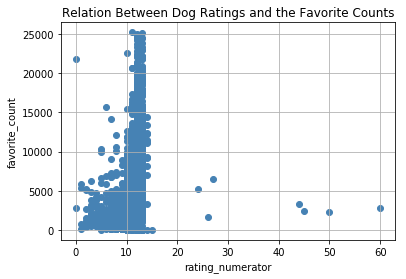

In [74]:
#Plot the rating_numerator with favorite_count0
plt.scatter(x= df['rating_numerator'], y= df['favorite_count'], color= 'steelblue')
plt.xlabel('rating_numerator')
plt.ylabel('favorite_count')
plt.grid()
plt.title('Relation Between Dog Ratings and the Favorite Counts');

From the plot we could see that except the outliers which have a rating_numerator larger than 20, most of the dogs whose rating_numerator are higher than 10 have more favorite counts than the ones have ratings lower than 10. Next, I am going to drop the outliers and plot again.

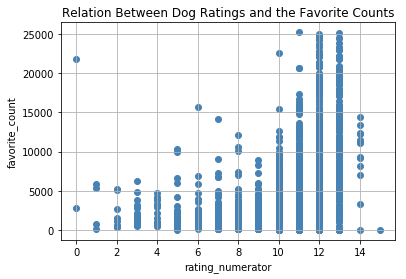

In [75]:
#Drop outliers and plot again
plt.scatter(x= df.query('rating_numerator<=20')['rating_numerator'], y= df.query('rating_numerator<=20')['favorite_count'], color= 'steelblue')
plt.xlabel('rating_numerator')
plt.ylabel('favorite_count')
plt.grid()
plt.title('Relation Between Dog Ratings and the Favorite Counts');

From the revised plot we could say that in genernal, dogs with higher ratings will get more favorite count.

The second question I want to ask is if people like a dog, whether they will retweet the twitter of this dog?

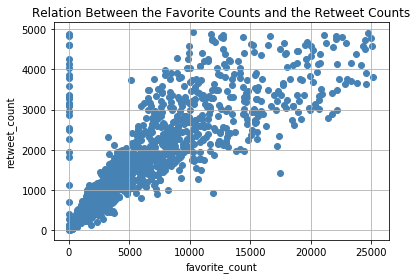

In [76]:
#Plot retweet and favorite
plt.scatter(x= df['favorite_count'], y= df['retweet_count'], color= 'steelblue')
plt.ylabel('retweet_count')
plt.xlabel('favorite_count')
plt.grid()
plt.title('Relation Between the Favorite Counts and the Retweet Counts');

It is clear that the more favorite count is related with the more retweet count. The data with 0 favorite count are the outliers. Next, I am going to drop the ourliers and plot again.

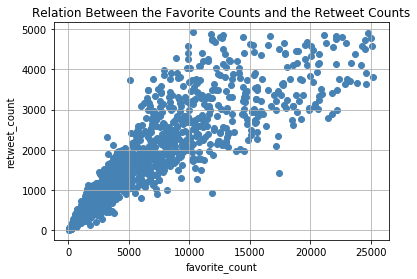

In [77]:
#Drop the outliers and plot again
plt.scatter(x= df.query('favorite_count!=0')['favorite_count'], y= df.query('favorite_count!=0')['retweet_count'], color= 'steelblue')
plt.ylabel('retweet_count')
plt.xlabel('favorite_count')
plt.grid()
plt.title('Relation Between the Favorite Counts and the Retweet Counts');

After the ourliers removed, it is clear to say that the retweet count has a positive relation with the favorite count.

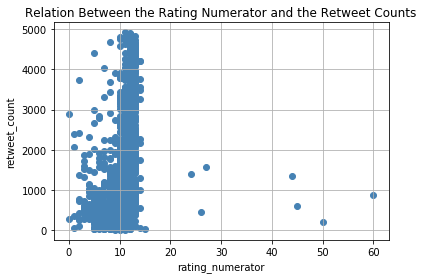

In [78]:
#Plot rating_numerator and retweet_count
plt.scatter(x= df['rating_numerator'], y= df['retweet_count'], color= 'steelblue')
plt.ylabel('retweet_count')
plt.xlabel('rating_numerator')
plt.grid()
plt.title('Relation Between the Rating Numerator and the Retweet Counts');

We also plot the retweet count and the rating numerator, it is clear the rating numerators which larger than 20 are outliers and should be deleted.

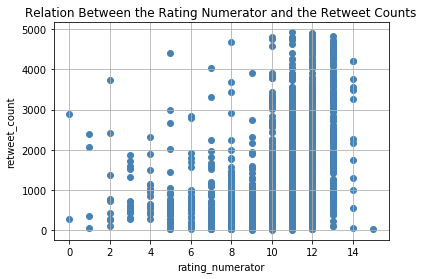

In [79]:
#Drop outliers and plot again
plt.scatter(x= df.query('rating_numerator<=20')['rating_numerator'], y= df.query('rating_numerator<=20')['retweet_count'], color= 'steelblue')
plt.ylabel('retweet_count')
plt.xlabel('rating_numerator')
plt.grid()
plt.title('Relation Between the Rating Numerator and the Retweet Counts');

From this revised plot it is not hard to find that dogs with higher rating numerator have more chance to have more retweet_count.

In [80]:
#Use linear regression to test whether favorite_count and rating_numerator influence the retweet_count
df['intercept']= 1
lm= sm.OLS(df['retweet_count'],df[['intercept', 'favorite_count', 'rating_numerator']])
results= lm.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.709     
Dependent Variable: retweet_count    AIC:                28340.8659
Date:               2021-02-13 20:27 BIC:                28357.3492
No. Observations:   1798             Log-Likelihood:     -14167.   
Df Model:           2                F-statistic:        2194.     
Df Residuals:       1795             Prob (F-statistic): 0.00      
R-squared:          0.710            Scale:              4.0958e+05
-------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
-------------------------------------------------------------------
intercept        361.5038  55.7804  6.4808 0.0000 252.1026 470.9051
favorite_count     0.1923   0.0030 63.1994 0.0000   0.1863   0.1983
rating_numerator   6.4531   5.3484  1.2065 0.2278  -4.0366  16.9428
-------------------------------------------------------------------
Omnibus:              994.817      Durbin-Watson:         1.659    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      10228.901
Skew:                 2.410        Prob(JB):              0.000    
Kurtosis:             13.645       Condition No.:         26646    
===================================================================
* The condition number is large (3e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

For each additional unit increase in the favorite_count, the retweet_count is expected to increase by 0.19 as long as all the other varibales stay the same. The P-value suggests that this is statistically significant. For each additional unit increase in the rating_numerator, the retweet_count is expected to increase by 6.5 as long as all the other varibales stay the same. However, the P-value suggests that this is statistically insignificant.

Last question I want to ask is wheter the algorithm could predict the picture to be a dog?

In [81]:
#Calculate the possibility the algorithm predict a pic to be a dog
p1_true= df.query('p1_dog==True').shape[0]/df.shape[0]
p2_true= df.query('p2_dog==True').shape[0]/df.shape[0]
p3_true= df.query('p3_dog==True').shape[0]/df.shape[0]

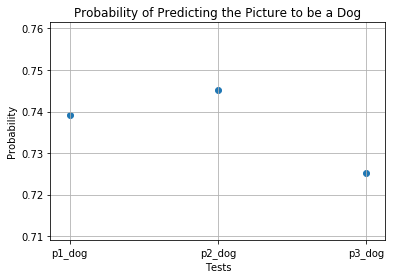

In [82]:
x_label= np.array([1,2,3])
y_label= np.array([p1_true, p2_true, p3_true])
plt.xticks(x_label,['p1_dog', 'p2_dog', 'p3_dog'])
plt.title('Probability of Predicting the Picture to be a Dog')
plt.xlabel('Tests')
plt.ylabel('Probability')
plt.grid()
plt.scatter(x= x_label,y= y_label);

From this plot we could see the success rate of predciting the picture to be a dog is around 74%. It is not a very high rate. The algorithm needs to be improved.

Conclusion: In this project, we analyzed which factor influence the retweet_count and whether the algorithm is good at predicting whether a image is a dog. We used linear regression to find that favorite_count has a positive influence on retweet_count. Also we found the algorithm could figure out whether a image is the picture of dog with a success rate above 70%.